In [10]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')

In [71]:
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

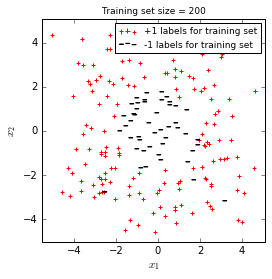

In [15]:
#determine predictions for the training set
# yplus = np.ma.masked_where(y_train<=0, y_train)
# xplus = x_train[~np.array(yplus.mask)]
# yminus = np.ma.masked_where(y_train>0, y_train)
# xminus = x_train[~np.array(yminus.mask)]

positive_index = np.where(y_train>0)[0]
x_positive = x_train[positive_index]

negative_index = np.where(y_train<=0)[0]
x_negative = x_train[negative_index]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (x_positive[:,0], x_positive[:,1], marker='+', c='r', label = '+1 labels for training set')
minuses = ax.scatter (x_negative[:,0], x_negative[:,1], marker=r'$-$', c='b', label = '-1 labels for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [87]:
y_train_label_flat = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train)))
y_train_label = y_train_label_flat.reshape(-1, 1)
# y_test_label = list(map(lambda x: 1 if x > 0 else 0, y_test))

In [36]:
from collections import Counter
from scipy.stats import entropy

# Decision Tree Classifier

In [48]:
#Prob_list = [value/float(sum(label_cnt.values())) for value in label_cnt.values()]

In [94]:
def compute_entropy(train_label):
    label_cnt = Counter(train_label.reshape(len(train_label)))
    prob_list = [value/float(sum(label_cnt.values())) for value in label_cnt.values()]
    entropy = 0.
    for prob in prob_list:
        if prob == 0.:
            pass
        else:
            entropy += -1. * prob * np.log(prob)
    return entropy

#def compute_gini()

In [91]:
y_train_label.reshape(len(y_train_label))

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [99]:
class DTree:
    def __init__(self, train_data, train_label, depth=0, min_sample=5, max_depth=10):
        self.train = train_data   
        
        label_cnt = Counter(train_label.reshape(len(train_label)))
        self.label = label_cnt.most_common(1)[0][0]
        
        if len(train_data) < min_sample or depth > max_depth:
            self.is_leaf = True
            # self.num_leaf = 1
            return

        self.split_id, self.split_value = self.split_tree(train_data, train_label)

        if self.split_id == -1:
            self.is_leaf = True
            #self.num_leaf = 1
            return

        self.is_leaf = False
        left_index = np.where(train_data[:, self.split_id] <= self.split_value)
        right_index = np.where(train_data[:, self.split_id] > self.split_value)
        
        self.left = DTree(train_data[left_index], train_label[left_index], depth+1)
        self.right = DTree(train_data[right_index], train_label[right_index], depth+1)
#         self.left = DTree([row for row in train if row[self.split_id] <= self.split_value], target_id, depth + 1)
#         self.right = DTree([row for row in train if row[self.split_id] > self.split_value], target_id, depth + 1)
#         self.num_leaf = self.left.num_leaf + self.right.num_leaf

    def split_tree(self, train_data, train_label):
        split_id = -1
        split_value = np.inf
        min_entropy = compute_entropy(train_label)
        
        for attr_id in range(train_data.shape[1]):
            attr_value = sorted(list(set(train_data[:, attr_id])))
            for i in range(len(attr_value) - 1):
                v = (attr_value[i] + attr_value[i + 1]) / 2.
                left_index_temp = np.where(train_data[:, attr_id] <= v)[0]
                right_index_temp = np.where(train_data[:, attr_id] > v)[0]
                left_entropy = compute_entropy(train_label[left_index_temp])
                right_entropy = compute_entropy(train_label[right_index_temp])
                entropy_ave = (len(left_index_temp) * left_entropy + len(right_index_temp) * right_entropy) / float(len(train_label))
                if entropy_ave < min_entropy:
                    split_id = attr_id
                    split_value = v
                    min_entropy = left_entropy + right_entropy

        return split_id, split_value

    def predict(self, instance):
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict(instance)
        else:
            return self.right.predict(instance)

In [101]:
Tree_model = DTree(x_train, y_train_label)

In [117]:
Tree_model.right.train

array([[-1.96174616,  4.61192419]])

In [133]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

In [123]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5)

In [125]:
clf.fit(x_train, y_train_label)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [126]:
export_graphviz(clf, out_file='tree.dot')

In [134]:
! dot -Tpng tree.dot -o tree.png

'dot' is not recognized as an internal or external command,
operable program or batch file.


In [131]:
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

RuntimeError: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' path